In [ ]:
import os
import re
import pandas as pd
import numpy as np
import torch
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings("ignore")


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

nltk_data_dir = './nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)
os.environ['NLTK_DATA'] = nltk_data_dir


try:
    nltk.download('punkt', download_dir=nltk_data_dir, quiet=True)
except Exception as e:
    print(f"Warning: Could not download NLTK punkt: {e}")
    print("Will use simple string split for word counting instead.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

max_input_length = 512  
max_target_length = 512  
model_checkpoint = "t5-base"  
batch_size = 4  
learning_rate = 3e-5
epochs = 3  
weight_decay = 0.01


output_dir = "./content/drive/MyDrive/caps/improved-email-marketing-model"
model_save_name = "improved-email-marketing-model-final"


def count_words(text):
    if text is None or not isinstance(text, str):
        return 0
    try:
        return len(word_tokenize(text))
    except:
        return len(text.split())


def prepare_data(csv_path="/content/drive/MyDrive/caps/combined_file8000.csv"):  
    print(f"Loading data from {csv_path}")
    try:
        
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} emails")

        if 'generated_email' in df.columns and 'full_email' not in df.columns:
            df = df.rename(columns={'generated_email': 'full_email'})

        print("Data exploration:")
        print(f"Number of categories: {df['category'].nunique()}")
        print(f"Categories: {df['category'].unique()}")

        
        print(f"Missing values: {df.isnull().sum().sum()}")
        df = df.dropna(subset=['full_email'])  

        
        df['word_count'] = df['full_email'].apply(count_words)
        print(f"Average email length: {df['word_count'].mean():.1f} words")
        print(f"Min email length: {df['word_count'].min()} words")
        print(f"Max email length: {df['word_count'].max()} words")

        df_filtered = df[(df['word_count'] >= 80) & (df['word_count'] <= 270)]
        print(f"Keeping {len(df_filtered)} emails in the 80-270 word range")


        train_df, test_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['category'], random_state=42)

        print(f"Training set: {len(train_df)} examples")
        print(f"Testing set: {len(test_df)} examples")

        return train_df, test_df

    except Exception as e:
        print(f"Error preparing data: {e}")
        import traceback
        traceback.print_exc()
        return None, None


class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, max_input_length, max_target_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        business_name = row['business_name']
        category = row['category']
        prompt = row['prompt']
        email = row['full_email']

        input_text = (f"Create a detailed email marketing message for {business_name}, "
                     f"a {category} business. "
                     f"Include a clear subject line, opening, offer details, and call-to-action. "
                     f"Task: {prompt}")

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            email,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = input_encoding.input_ids.squeeze()
        attention_mask = input_encoding.attention_mask.squeeze()
        labels = target_encoding.input_ids.squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100 

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

def post_process_email(text, business_name):
    """Clean up generated email text for better readability"""
    text = re.sub(fr'\b{re.escape(business_name.lower())}\b', business_name, text, flags=re.IGNORECASE)

    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'\n\s*\n+', '\n\n', text)  

    text = re.sub(r'\.(?=[A-Z])', '. ', text)
    text = re.sub(r',(?=[^\s])', ', ', text)

    if '[SUBJECT:' not in text and not text.startswith('SUBJECT:'):
        lines = text.split('\n')
        if len(lines) > 0 and len(lines[0]) < 100 and len(lines[0]) > 3:
            text = f"[SUBJECT: {lines[0].strip()}]\n\n" + '\n'.join(lines[1:])

    cta_patterns = [r'\[CTA:(.*?)\]', r'CTA:(.*?)(?=\n|$)']
    for pattern in cta_patterns:
        match = re.search(pattern, text)
        if match:
            cta_text = match.group(1).strip()
            text = re.sub(pattern, f"[CTA: {cta_text}]", text)

    return text.strip()

def train_model(train_df, test_df):
    try:
        print("\nInitializing tokenizer and model...")
        tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)
        model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)

        print("Preparing datasets...")
        train_dataset = EmailDataset(train_df, tokenizer, max_input_length, max_target_length)
        eval_dataset = EmailDataset(test_df, tokenizer, max_input_length, max_target_length)

        data_collator = DataCollatorForSeq2Seq(
            tokenizer=tokenizer,
            model=model,
            padding="longest"
        )

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print(f"GPU memory before loading model: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

        training_args = Seq2SeqTrainingArguments(
            output_dir=output_dir,
            eval_strategy="epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=weight_decay,
            save_total_limit=2,
            num_train_epochs=epochs,
            predict_with_generate=True,
            logging_dir="./logs",
            logging_steps=100,
            save_strategy="epoch",
            fp16=False,  
            gradient_accumulation_steps=2,  
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            report_to="tensorboard",
            logging_first_step=True
        )



        trainer = Seq2SeqTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator
        )

        print("\nStarting model training...")
        trainer.train()

        model.save_pretrained(model_save_name)
        tokenizer.save_pretrained(model_save_name)
        print(f"Model saved to {model_save_name}")

        return model, tokenizer

    except Exception as e:
        print(f"Error in training: {e}")
        import traceback
        traceback.print_exc()
        return None, None


def load_email_model(model_dir=model_save_name):
    try:
        print(f"Loading model from {model_dir}...")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        model = T5ForConditionalGeneration.from_pretrained(model_dir)
        tokenizer = T5Tokenizer.from_pretrained(model_dir)

        model = model.to(device)
        print("Model loaded successfully")

        return model, tokenizer
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return None, None


def generate_email(business_name, category, prompt, model=None, tokenizer=None, model_dir=model_save_name):
    if model is None or tokenizer is None:
        model, tokenizer = load_email_model(model_dir)
        if model is None or tokenizer is None:
            return "Failed to load the model"

    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        input_text = (f"Create a specific, detailed email marketing message for {business_name}, "
                     f"a {category} business. "
                     f"Include subject line, greeting, body with offer details, "
                     f"clear call-to-action, and sign-off. Write between 100-250 words. "
                     f"Task: {prompt}")

        input_length = len(input_text.split())
        print(f"Input length: {input_length} words")

        if input_length > max_input_length // 2:  
            print("Warning: Input text may be too long, truncating...")

        input_encoding = tokenizer(
            input_text,
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True
        )

        input_ids = input_encoding.input_ids.to(device)
        attention_mask = input_encoding.attention_mask.to(device)

        print(f"Tokenized input shape: {input_ids.shape}")

        model.eval()

        with torch.no_grad(): 
            try:
                outputs = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=max_target_length,
                    num_beams=4,
                    temperature=0.8,
                    top_p=0.9,
                    repetition_penalty=1.2,
                    length_penalty=1.0,
                    early_stopping=True,
                    do_sample=True
                )

                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

                processed_text = post_process_email(generated_text, business_name)

                word_count = count_words(processed_text)
                print(f"Generated {word_count} words")

                return processed_text

            except RuntimeError as e:
                if 'CUDA' in str(e):
                    print(f"CUDA error during generation: {e}")
                    print("Falling back to CPU...")

                    cpu_model = model.to('cpu')
                    cpu_input_ids = input_ids.to('cpu')
                    cpu_attention_mask = attention_mask.to('cpu')

                    outputs = cpu_model.generate(
                        input_ids=cpu_input_ids,
                        attention_mask=cpu_attention_mask,
                        max_length=max_target_length,
                        num_beams=2,  
                        temperature=1.0,
                        do_sample=False  
                    )

                    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                    processed_text = post_process_email(generated_text, business_name)

                    if torch.cuda.is_available():
                        model.to(device)

                    return processed_text
                else:
                    raise e 
    except Exception as e:
        print(f"Error generating email: {e}")
        import traceback
        traceback.print_exc()
        return f"Failed to generate email: {str(e)[:200]}..."

def evaluate_model(model, tokenizer, test_df, num_samples=5):
    print("\nEvaluating model performance on sample examples:")

    samples = test_df.sample(num_samples)

    for i, row in enumerate(samples.itertuples(), 1):
        print(f"\nExample {i}:")
        print(f"Business: {row.business_name} ({row.category})")
        print(f"Prompt: {row.prompt}")

        try:
            generated = generate_email(
                row.business_name,
                row.category,
                row.prompt,
                model=model,
                tokenizer=tokenizer
            )

            print(f"\nGenerated email ({count_words(generated)} words):")
            print("-" * 50)
            print(generated)
            print("-" * 50)

            original_word_count = count_words(row.full_email)
            print(f"Original email had {original_word_count} words")

        except Exception as e:
            print(f"Error evaluating example: {e}")
            import traceback
            traceback.print_exc()

def test_custom_cases(model, tokenizer):
    print("\nTesting with custom examples:")

    test_cases = [
        {
            "business_name": "Mountain Resort",
            "category": "Hotels",
            "prompt": "Send a promotional email about weekend discounts"
        },
        {
            "business_name": "CloudSync",
            "category": "Software Services",
            "prompt": "Notify about a new feature release"
        },
        {
            "business_name": "Wellness Center",
            "category": "Healthcare Clinics",
            "prompt": "Promote seasonal health checkups"
        },
        {
            "business_name": "Urban Fitness",
            "category": "Fitness Centers",
            "prompt": "Invite members to a new yoga class"
        },
        {
            "business_name": "Fashion Forward",
            "category": "Clothing Boutiques",
            "prompt": "Announce end-of-season sale"
        }
    ]

    for i, test in enumerate(test_cases, 1):
        print(f"\nTest Case {i}:")
        print(f"Business: {test['business_name']} ({test['category']})")
        print(f"Prompt: {test['prompt']}")

        try:
            generated = generate_email(
                test["business_name"],
                test["category"],
                test["prompt"],
                model=model,
                tokenizer=tokenizer
            )

            print(f"\nGenerated email ({count_words(generated)} words):")
            print("-" * 50)
            print(generated)
            print("-" * 50)

        except Exception as e:
            print(f"Error testing example: {e}")
            import traceback
            traceback.print_exc()

def main():

    train_df, test_df = prepare_data()
    if train_df is None or test_df is None:
        print("Failed to prepare data. Exiting.")
        return

    if os.path.exists(model_save_name):
        print(f"Found existing model at {model_save_name}")
        train_new = input("Train new model? (y/n): ").lower() == 'y'
    else:
        train_new = True

    if train_new:
        model, tokenizer = train_model(train_df, test_df)
    else:
        model, tokenizer = load_email_model()

    if model is None or tokenizer is None:
        print("Failed to get a working model. Exiting.")
        return

    evaluate_model(model, tokenizer, test_df)

    test_custom_cases(model, tokenizer)

    print("\nEmail marketing model pipeline completed!")

if __name__ == "__main__":
    main()

Using device: cuda
Loading data from /content/drive/MyDrive/caps/combined_file8000.csv
Loaded 8857 emails
Data exploration:
Number of categories: 10
Categories: ['Hotels' 'Software Services' 'Food Delivery' 'Healthcare Clinics'
 'Book Stores' 'Beauty & Salons' 'Fitness Centers' 'Pet Stores'
 'Educational Services' 'Clothing Boutiques']
Missing values: 0
Average email length: 155.7 words
Min email length: 100 words
Max email length: 198 words
Keeping 8857 emails in the 80-270 word range
Training set: 7971 examples
Testing set: 886 examples

Initializing tokenizer and model...


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Preparing datasets...
GPU memory before loading model: 0.00 GB

Starting model training...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.809000,1.447139
2,1.500400,1.238788


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model saved to improved-email-marketing-model-final

Evaluating model performance on sample examples:

Example 1:
Business: Hotel Business 8 (Hotels)
Prompt: Send birthday wishes with a discount
Input length: 37 words
Tokenized input shape: torch.Size([1, 58])
Generated 141 words

Generated email (141 words):
--------------------------------------------------
[SUBJECT: Happy Birthday, [Name]! Treat Yourself to a Day of Happiness!] Hi [Name], Happy Birthday from all of us at [Hotel Name]! We hope you have a wonderful day filled with joy and celebration. To help you celebrate, we'd like to offer you a special birthday discount! For a limited time, enjoy [Discount Percentage]% off your next stay at [Hotel Name]! This offer is valid for stays between [Date] and [Date]. Here are a few things you can do to redeem your birthday discount: * Use code BIRTHDAY20 at checkout. * Use code BIRTHDAY20 at checkout. * Use code BIRTHDAY20 at checkout to redeem your birthday discount. * Use code BIRTHDAY

In [ ]:
output_dir = "/content/drive/MyDrive/caps/improved-email-marketing-model"

In [ ]:
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

NameError: name 'model' is not defined

In [ ]:
import shutil
import os

original_path = "/content/improved-email-marketing-model-final"
new_path = "/content/drive/MyDrive/caps"


os.makedirs(new_path, exist_ok=True)


folder_name = os.path.basename(original_path)


destination_path = os.path.join(new_path, folder_name)


shutil.move(original_path, destination_path)

print(f"Moved folder to: {destination_path}")


Moved folder to: /content/drive/MyDrive/caps/improved-email-marketing-model-final


In [ ]:
import os
import re
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

MODEL_PATH = "/content/drive/MyDrive/caps/improved-email-marketing-model-final"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def count_words(text):
    if text is None or not isinstance(text, str):
        return 0
    return len(text.split())

def post_process_email(text, business_name):
    """Clean up generated email text for better readability"""
    text = re.sub(fr'\b{re.escape(business_name.lower())}\b', business_name, text, flags=re.IGNORECASE)

    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'\n\s*\n+', '\n\n', text) 


    text = re.sub(r'\.(?=[A-Z])', '. ', text)
    text = re.sub(r',(?=[^\s])', ', ', text)

    if '[SUBJECT:' not in text and not text.startswith('SUBJECT:'):
        lines = text.split('\n')
        if len(lines) > 0 and len(lines[0]) < 100 and len(lines[0]) > 3:
            text = f"[SUBJECT: {lines[0].strip()}]\n\n" + '\n'.join(lines[1:])


    cta_patterns = [r'\[CTA:(.*?)\]', r'CTA:(.*?)(?=\n|$)']
    for pattern in cta_patterns:
        match = re.search(pattern, text)
        if match:
            cta_text = match.group(1).strip()
            text = re.sub(pattern, f"[CTA: {cta_text}]", text)

    sentences = re.split(r'(?<=[.!?])\s+', text)
    unique_sentences = []
    for sentence in sentences:
        if sentence not in unique_sentences:
            unique_sentences.append(sentence)

    text = " ".join(unique_sentences)

    return text.strip()


def generate_email(business_name, category, prompt, temperature=0.7, repetition_penalty=1.5):
    try:
        print(f"Loading model from {MODEL_PATH}...")

        tokenizer = T5Tokenizer.from_pretrained(MODEL_PATH)
        model = T5ForConditionalGeneration.from_pretrained(MODEL_PATH).to(device)

        input_text = (f"Create a detailed email marketing message for {business_name}, "
                     f"a {category} business. "
                     f"Include a clear subject line, opening, offer details, and call-to-action. "
                     f"Task: {prompt}")

        print(f"Generating email for {business_name}...")

        input_encoding = tokenizer(
            input_text,
            return_tensors="pt",
            max_length=512,
            truncation=True
        ).to(device)

        outputs = model.generate(
            input_ids=input_encoding.input_ids,
            attention_mask=input_encoding.attention_mask,
            max_length=512,
            num_beams=5,            
            temperature=temperature, 
            top_p=0.9,             
            repetition_penalty=repetition_penalty,  
            length_penalty=1.0,
            early_stopping=True,
            do_sample=True        
        )


        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        processed_text = post_process_email(generated_text, business_name)

        word_count = count_words(processed_text)

        return processed_text, word_count

    except Exception as e:
        print(f"Error generating email: {e}")
        import traceback
        traceback.print_exc()
        return f"Failed to generate email: {str(e)}", 0


test_cases = [
    {
        "business_name": "Serene Spa Retreat",
        "category": "Beauty & Salons",
        "prompt": "Promote a new seasonal massage package with discount"
    },
    {
        "business_name": "TechNinjas",
        "category": "Software Services",
        "prompt": "Announce a new cybersecurity service for small businesses"
    },
    {
        "business_name": "Bookworm Haven",
        "category": "Book Stores",
        "prompt": "Invite customers to a book signing event with a popular author"
    },
    {
        "business_name": "Fresh Fields Grocery",
        "category": "Food Delivery",
        "prompt": "Promote new organic produce selection with free delivery"
    },
    {
        "business_name": "Perfect Paws Veterinary",
        "category": "Pet Stores",
        "prompt": "Remind customers about seasonal pet vaccinations"
    }
]

def run_tests():
    print("\n===== TESTING SAVED EMAIL MARKETING MODEL =====\n")

    for i, test in enumerate(test_cases, 1):
        print(f"\n===== TEST CASE {i} =====")
        print(f"Business: {test['business_name']} ({test['category']})")
        print(f"Prompt: {test['prompt']}")

        print("\n----- Standard Generation -----")
        email, word_count = generate_email(
            test["business_name"],
            test["category"],
            test["prompt"],
            temperature=0.7,
            repetition_penalty=1.5
        )

        print(f"\nGenerated email ({word_count} words):")
        print("-" * 70)
        print(email)
        print("-" * 70)

        if "repetition" in input("Did you notice repetition? Type 'repetition' if yes, or press Enter to continue: ").lower():
            print("\n----- More Aggressive Repetition Handling -----")
            email, word_count = generate_email(
                test["business_name"],
                test["category"],
                test["prompt"],
                temperature=0.9,  
                repetition_penalty=2.0 
            )

            print(f"\nImproved email ({word_count} words):")
            print("-" * 70)
            print(email)
            print("-" * 70)

if __name__ == "__main__":
    run_tests()

Using device: cuda

===== TESTING SAVED EMAIL MARKETING MODEL =====


===== TEST CASE 1 =====
Business: Serene Spa Retreat (Beauty & Salons)
Prompt: Promote a new seasonal massage package with discount

----- Standard Generation -----
Loading model from /content/drive/MyDrive/caps/improved-email-marketing-model-final...
Generating email for Serene Spa Retreat...

Generated email (118 words):
----------------------------------------------------------------------
[SUBJECT: Pamper Yourself This Season: Discounted Massage Package Inside!] Hi [Name], As the leaves change and the air gets crisper, it's the perfect time to relax and unwind. At [Salon Name], we're offering a special discount on our seasonal massage package! For a limited time, enjoy 20% off your entire package when you book before October 31st! Imagine waking up refreshed and rejuvenated with a relaxing facial, a relaxing facial, or a relaxing facial. This offer is valid until October 31st, so don't miss out! To redeem your di

KeyboardInterrupt: Interrupted by user

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

def load_email_model(model_dir):
    try:
        tokenizer = T5Tokenizer.from_pretrained(model_dir)
        model = T5ForConditionalGeneration.from_pretrained(model_dir)
        return model, tokenizer
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

def generate_email(business_name, category, prompt, model, tokenizer, max_length=512):
    input_text = f"Business Name: {business_name}. Category: {category}. Prompt: {prompt}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=5,
            early_stopping=True
        )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

def simple_email_generator(model_dir, prompt, category):

    model, tokenizer = load_email_model(model_dir)
    if model is None or tokenizer is None:
        print("Failed to load model.")
        return

    business_name = "Example Business"

    email_content = generate_email(
        business_name=business_name,
        category=category,
        prompt=prompt,
        model=model,
        tokenizer=tokenizer
    )

    print("\n=== Generated Email ===\n")
    print(email_content)
    print("\n========================\n")


In [ ]:
model_dir = "/content/drive/MyDrive/caps/improved-email-marketing-model-final"

prompt = "Introducing our new summer collection."
category = "Clothing Boutiques"

simple_email_generator(model_dir, prompt, category)


Loading model from /content/drive/MyDrive/caps/improved-email-marketing-model-final...
Model loaded successfully

=== Generated Email ===

[SUBJECT: Introducing Our New Summer Collection!] Hi [Customer Name], Summer is officially here, and we're so excited to introduce our brand new summer collection! We've been working hard to curate a collection that's sure to keep you cool and comfortable all season long. We've hand-picked a selection of styles designed to keep you cool and comfortable all season long. Whether you're looking for a casual casual look, a chic top, or a casual top, we've got something for everyone. To celebrate the launch, we'd like to offer you a special discount! Use code **SUMMER20** at checkout. This offer is valid until October 27th, so don't miss out! Here are a few things you can expect from us: * Comfortable and stylish * Comfortable fabrics * Comfortable and versatile * Comfortable shoes Ready to refresh your summer wardrobe? [[CTA: Shop Our Summer Collection 

In [ ]:

import pandas as pd

def qualitative_evaluation(generated_emails, original_emails):
    """
    Performs a qualitative evaluation of generated emails compared to original emails.

    Args:
        generated_emails: A list of generated email strings.
        original_emails: A list of original email strings corresponding to the generated emails.

    Returns:
        A pandas DataFrame containing the evaluation scores.
    """

    num_emails = len(generated_emails)
    if num_emails != len(original_emails):
        raise ValueError("The number of generated and original emails must be the same.")

    evaluation_data = []
    for i in range(num_emails):
        generated = generated_emails[i]
        original = original_emails[i]

        coherence_score = 0  
        relevance_score = 0  
        fluency_score = 0  

        generated_word_count = len(generated.split())
        original_word_count = len(original.split())
        length_diff = abs(generated_word_count - original_word_count)


        evaluation_data.append({
            "Email_Index": i,
            "Coherence": coherence_score,
            "Relevance": relevance_score,
            "Fluency": fluency_score,
            "Generated_Length": generated_word_count,
            "Original_Length": original_word_count,
            "Length_Difference": length_diff,
            "Generated_Email": generated,
            "Original_Email": original

        })

    evaluation_df = pd.DataFrame(evaluation_data)
    return evaluation_df


generated_email_examples = [
  "This is the first generated email.",
  "Second generated email here.",
  "Another generated email."
]

original_email_examples = [
    "First original email.",
    "This is the second original email.",
    "The third original one"
]

evaluation_results = qualitative_evaluation(generated_email_examples, original_email_examples)
evaluation_results



NameError: name 'test_df' is not defined

Using device: cuda
Loading model from /content/drive/MyDrive/caps/improved-email-marketing-model-final...
Model loaded successfully
Loading test data...
Enter the path to your CSV file (default: combined_file8000.csv): /content/drive/MyDrive/caps/combined_file8000.csv
Splitting data into train/test sets...
Loaded 886 test examples
Enter number of samples to evaluate (default: 50): 50

Evaluating model on 50 test samples...


100%|██████████| 50/50 [04:43<00:00,  5.67s/it]


Error calculating BLEU score: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Error calculating BLEU score: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tok

Generating examples: 100%|██████████| 10/10 [00:56<00:00,  5.60s/it]

Detailed evaluation results saved to /content/drive/MyDrive/caps directory

Evaluation complete!


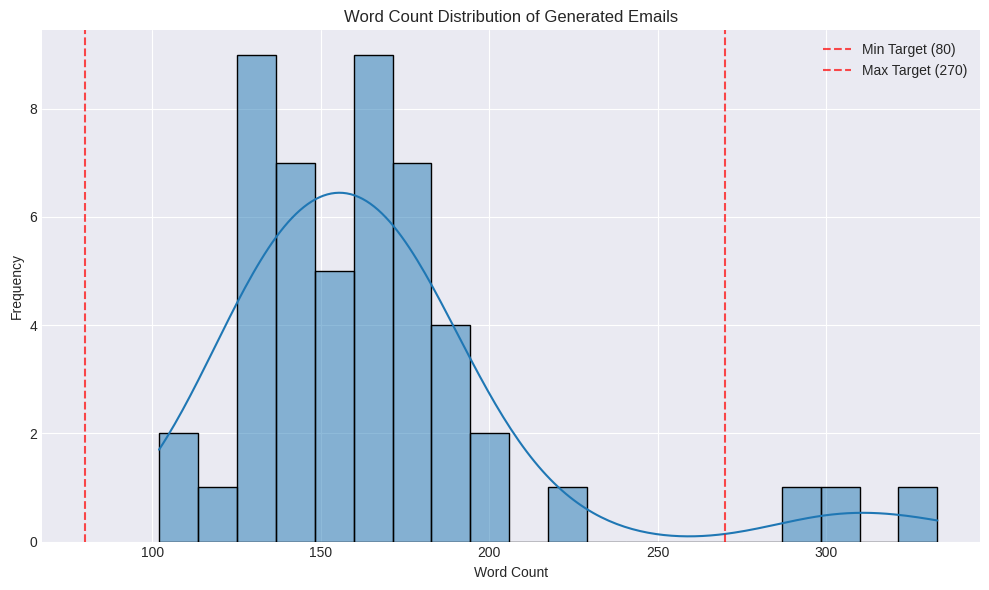

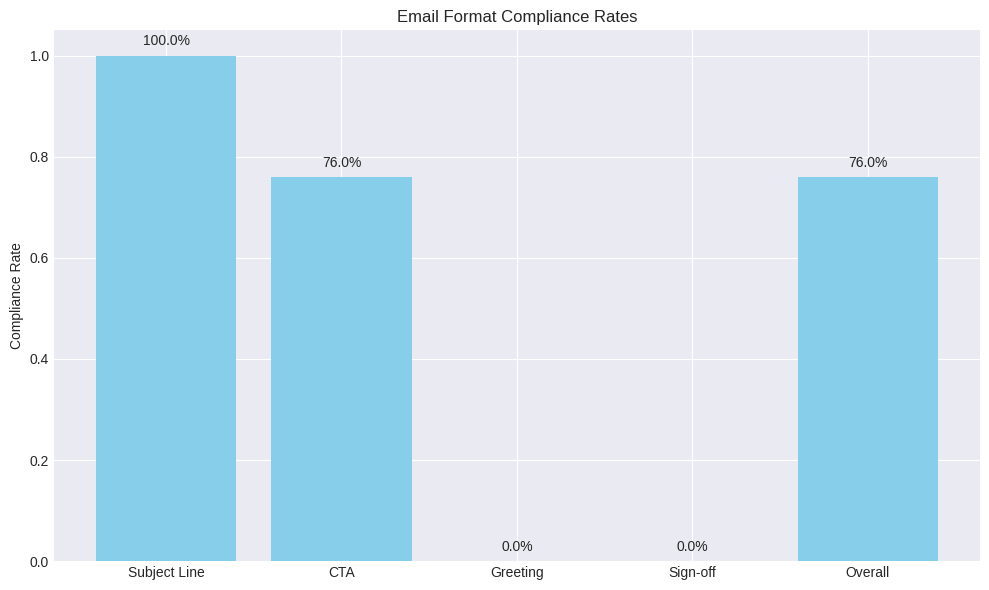

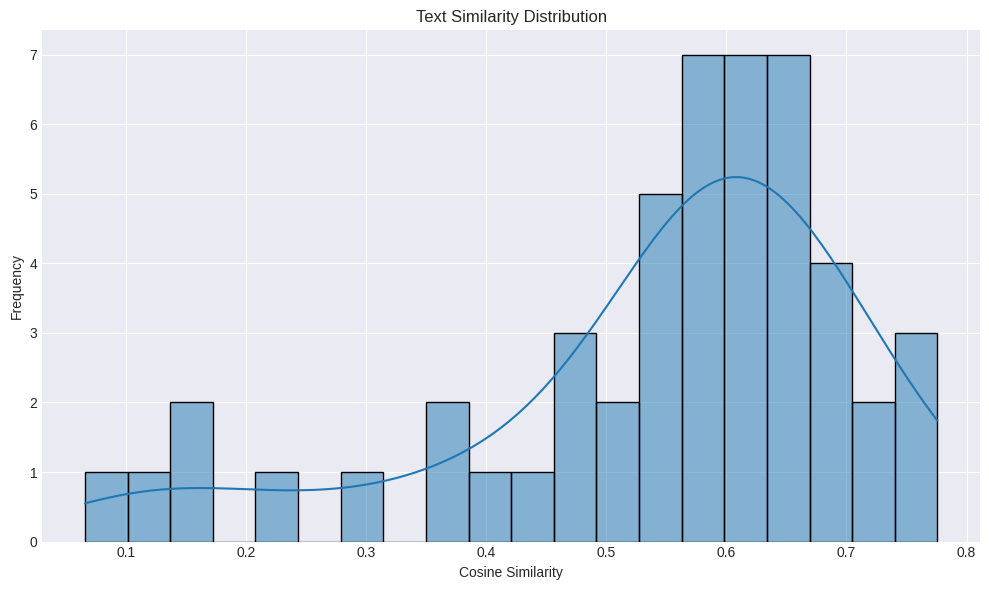

<Figure size 1200x800 with 0 Axes>

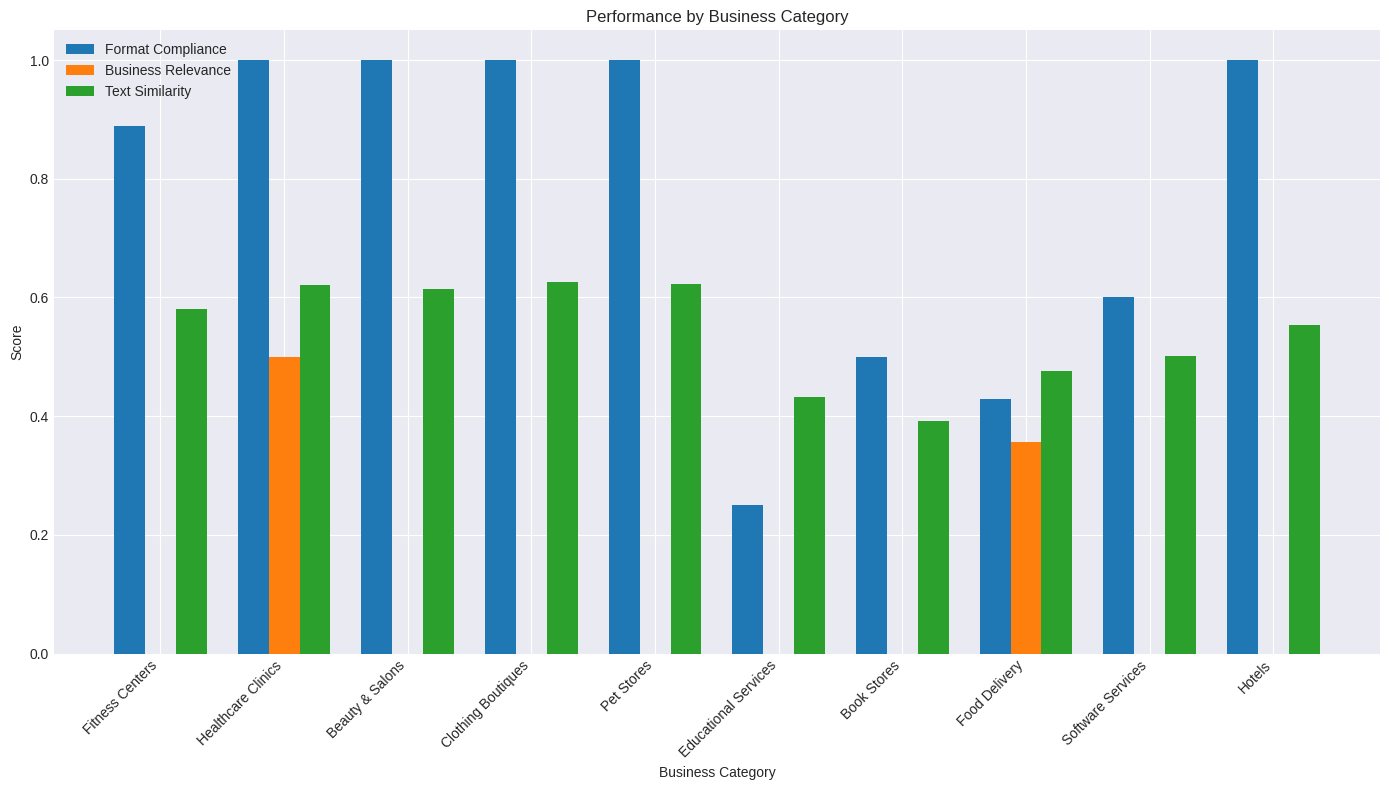

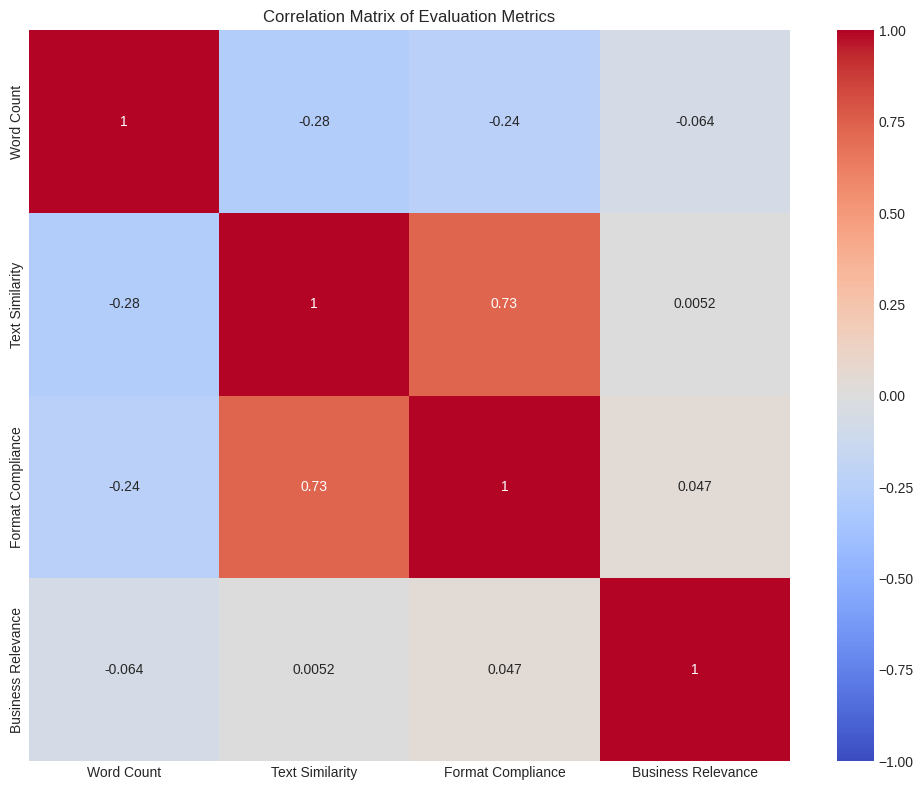

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import re
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

try:
    nltk.download('punkt', quiet=True)
except:
    print("NLTK punkt already downloaded or couldn't be downloaded")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

max_input_length = 512
max_target_length = 512
model_save_name = "/content/drive/MyDrive/caps/improved-email-marketing-model-final"

def count_words(text):
    if text is None or not isinstance(text, str):
        return 0
    try:
        return len(word_tokenize(text))
    except:
        return len(text.split())

def load_email_model(model_dir=model_save_name):
    try:
        print(f"Loading model from {model_dir}...")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        model = T5ForConditionalGeneration.from_pretrained(model_dir)
        tokenizer = T5Tokenizer.from_pretrained(model_dir)

        model = model.to(device)
        print("Model loaded successfully")

        return model, tokenizer
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def post_process_email(text, business_name):
    """Clean up generated email text for better readability"""
    text = re.sub(fr'\b{re.escape(business_name.lower())}\b', business_name, text, flags=re.IGNORECASE)

    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'\n\s*\n+', '\n\n', text)  

    text = re.sub(r'\.(?=[A-Z])', '. ', text)
    text = re.sub(r',(?=[^\s])', ', ', text)

    if '[SUBJECT:' not in text and not text.startswith('SUBJECT:'):
        lines = text.split('\n')
        if len(lines) > 0 and len(lines[0]) < 100 and len(lines[0]) > 3:
            text = f"[SUBJECT: {lines[0].strip()}]\n\n" + '\n'.join(lines[1:])

    cta_patterns = [r'\[CTA:(.*?)\]', r'CTA:(.*?)(?=\n|$)']
    for pattern in cta_patterns:
        match = re.search(pattern, text)
        if match:
            cta_text = match.group(1).strip()
            text = re.sub(pattern, f"[CTA: {cta_text}]", text)

    return text.strip()

def generate_email(business_name, category, prompt, model, tokenizer):
    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        input_text = (f"Create a specific, detailed email marketing message for {business_name}, "
                     f"a {category} business. "
                     f"Include subject line, greeting, body with offer details, "
                     f"clear call-to-action, and sign-off. Write between 100-250 words. "
                     f"Task: {prompt}")

        input_encoding = tokenizer(
            input_text,
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True
        )

        input_ids = input_encoding.input_ids.to(device)
        attention_mask = input_encoding.attention_mask.to(device)

        model.eval()

        with torch.no_grad():
            try:
                outputs = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=max_target_length,
                    num_beams=4,
                    temperature=0.8,
                    top_p=0.9,
                    repetition_penalty=1.2,
                    length_penalty=1.0,
                    early_stopping=True,
                    do_sample=True
                )

                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                processed_text = post_process_email(generated_text, business_name)

                return processed_text

            except RuntimeError as e:
                if 'CUDA' in str(e):
                    print("CUDA error - falling back to CPU")

                    cpu_model = model.to('cpu')
                    cpu_input_ids = input_ids.to('cpu')
                    cpu_attention_mask = attention_mask.to('cpu')

                    outputs = cpu_model.generate(
                        input_ids=cpu_input_ids,
                        attention_mask=cpu_attention_mask,
                        max_length=max_target_length,
                        num_beams=2,
                        temperature=1.0,
                        do_sample=False
                    )

                    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                    processed_text = post_process_email(generated_text, business_name)

                    if torch.cuda.is_available():
                        model.to(device)

                    return processed_text
                else:
                    raise e

    except Exception as e:
        print(f"Error generating email: {e}")
        return "Failed to generate email"

def calculate_bleu(reference_texts, generated_texts):
    references = []
    candidates = []

    smoothie = SmoothingFunction().method1
    total_score = 0

    for ref, gen in zip(reference_texts, generated_texts):
        try:
            ref_tokens = word_tokenize(ref.lower())
            gen_tokens = word_tokenize(gen.lower())

            references.append([ref_tokens])
            candidates.append(gen_tokens)

            score = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smoothie)
            total_score += score
        except Exception as e:
            print(f"Error calculating BLEU score: {e}")

    try:
        corpus_score = corpus_bleu(references, candidates, smoothing_function=smoothie)
    except Exception as e:
        print(f"Error calculating corpus BLEU score: {e}")
        corpus_score = 0

    avg_score = total_score / len(reference_texts) if reference_texts else 0

    return {
        "corpus_bleu": corpus_score,
        "average_sentence_bleu": avg_score
    }

def check_format_compliance(email_text):
    has_subject = bool(re.search(r'\[SUBJECT:|^SUBJECT:', email_text))
    has_cta = bool(re.search(r'\[CTA:|CTA:', email_text))
    has_greeting = bool(re.search(r'^Dear|^Hello|^Hi\b|^Greetings|^Good (morning|afternoon|evening)', email_text, re.MULTILINE))
    has_signoff = bool(re.search(r'(Sincerely|Best|Regards|Yours|Thank you|Thanks|Cheers|Warm regards),?\s*\n', email_text))

    return {
        "has_subject": has_subject,
        "has_cta": has_cta,
        "has_greeting": has_greeting,
        "has_signoff": has_signoff,
        "overall_compliance": has_subject and has_cta
    }

def calculate_business_relevance(business_name, category, email_text):
    email_lower = email_text.lower()
    business_lower = business_name.lower()
    category_lower = category.lower()

    business_mentions = len(re.findall(r'\b' + re.escape(business_lower) + r'\b', email_lower))

    category_mentions = len(re.findall(r'\b' + re.escape(category_lower) + r'\b', email_lower))

    business_score = min(1.0, business_mentions / 3) 
    category_score = min(0.5, category_mentions / 2)  

    relevance_score = business_score + category_score

    return {
        "business_mentions": business_mentions,
        "category_mentions": category_mentions,
        "relevance_score": min(1.0, relevance_score)  
    }

def calculate_text_similarity(str1, str2):
    from sklearn.feature_extraction.text import TfidfVectorizer

    try:
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([str1, str2])

        from sklearn.metrics.pairwise import cosine_similarity
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

        return similarity
    except Exception as e:
        print(f"Error calculating similarity: {e}")
        return 0.0

def evaluate_model_quantitatively(model, tokenizer, test_df, num_samples=None):
    if num_samples is None:
        num_samples = min(100, len(test_df))
    else:
        num_samples = min(num_samples, len(test_df))

    print(f"\nEvaluating model on {num_samples} test samples...")
    samples = test_df.sample(num_samples)

    results = {
        "references": [],
        "generated": [],
        "word_counts": [],
        "format_compliance": [],
        "relevance_scores": [],
        "similarities": [],
        "category": [],
    }

    for _, row in tqdm(samples.iterrows(), total=num_samples):
        reference = row['full_email']
        business_name = row['business_name']
        category = row['category']
        prompt = row['prompt']

        generated = generate_email(business_name, category, prompt, model, tokenizer)

        results["references"].append(reference)
        results["generated"].append(generated)
        results["category"].append(category)

        word_count = count_words(generated)
        results["word_counts"].append(word_count)

        compliance = check_format_compliance(generated)
        results["format_compliance"].append(compliance)

        relevance = calculate_business_relevance(business_name, category, generated)
        results["relevance_scores"].append(relevance)

        similarity = calculate_text_similarity(reference, generated)
        results["similarities"].append(similarity)

    bleu_scores = calculate_bleu(results["references"], results["generated"])

    format_stats = {
        "subject_rate": sum(item["has_subject"] for item in results["format_compliance"]) / num_samples,
        "cta_rate": sum(item["has_cta"] for item in results["format_compliance"]) / num_samples,
        "greeting_rate": sum(item["has_greeting"] for item in results["format_compliance"]) / num_samples,
        "signoff_rate": sum(item["has_signoff"] for item in results["format_compliance"]) / num_samples,
        "overall_compliance": sum(item["overall_compliance"] for item in results["format_compliance"]) / num_samples
    }

    word_count_stats = {
        "mean": np.mean(results["word_counts"]),
        "median": np.median(results["word_counts"]),
        "min": np.min(results["word_counts"]),
        "max": np.max(results["word_counts"]),
        "in_range_rate": sum(80 <= count <= 270 for count in results["word_counts"]) / num_samples
    }

    relevance_stats = {
        "mean_score": np.mean([item["relevance_score"] for item in results["relevance_scores"]]),
        "business_mention_rate": sum(item["business_mentions"] > 0 for item in results["relevance_scores"]) / num_samples,
        "category_mention_rate": sum(item["category_mentions"] > 0 for item in results["relevance_scores"]) / num_samples
    }

    similarity_stats = {
        "mean": np.mean(results["similarities"]),
        "median": np.median(results["similarities"]),
        "min": np.min(results["similarities"]),
        "max": np.max(results["similarities"])
    }

    category_performance = {}
    for category in set(results["category"]):
        indices = [i for i, cat in enumerate(results["category"]) if cat == category]
        if indices:
            category_relevance = np.mean([results["relevance_scores"][i]["relevance_score"] for i in indices])
            category_similarity = np.mean([results["similarities"][i] for i in indices])
            category_compliance = np.mean([results["format_compliance"][i]["overall_compliance"] for i in indices])

            category_performance[category] = {
                "samples": len(indices),
                "relevance": category_relevance,
                "similarity": category_similarity,
                "compliance": category_compliance
            }

    evaluation_results = {
        "num_samples": num_samples,
        "bleu_scores": bleu_scores,
        "format_stats": format_stats,
        "word_count_stats": word_count_stats,
        "relevance_stats": relevance_stats,
        "similarity_stats": similarity_stats,
        "category_performance": category_performance,
        "raw_data": {
            "word_counts": results["word_counts"],
            "similarities": results["similarities"],
            "overall_compliance": [item["overall_compliance"] for item in results["format_compliance"]],
            "relevance_scores": [item["relevance_score"] for item in results["relevance_scores"]]
        }
    }

    return evaluation_results

def print_evaluation_results(results):
    print("\n" + "="*50)
    print("EMAIL MARKETING MODEL EVALUATION RESULTS")
    print("="*50)

    print("\n📊 GENERAL STATISTICS")
    print(f"Total samples evaluated: {results['num_samples']}")

    print("\n📝 BLEU SCORES")
    print(f"Corpus BLEU: {results['bleu_scores']['corpus_bleu']:.4f}")
    print(f"Average Sentence BLEU: {results['bleu_scores']['average_sentence_bleu']:.4f}")

    print("\n📋 FORMAT COMPLIANCE")
    print(f"Subject Line: {results['format_stats']['subject_rate']:.2%}")
    print(f"Call-to-Action: {results['format_stats']['cta_rate']:.2%}")
    print(f"Greeting: {results['format_stats']['greeting_rate']:.2%}")
    print(f"Sign-off: {results['format_stats']['signoff_rate']:.2%}")
    print(f"Overall Format Compliance: {results['format_stats']['overall_compliance']:.2%}")

    print("\n📏 WORD COUNT STATISTICS")
    print(f"Average Word Count: {results['word_count_stats']['mean']:.1f}")
    print(f"Median Word Count: {results['word_count_stats']['median']:.1f}")
    print(f"Range: {results['word_count_stats']['min']} - {results['word_count_stats']['max']} words")
    print(f"Within Target Range (80-270 words): {results['word_count_stats']['in_range_rate']:.2%}")

    print("\n🎯 BUSINESS RELEVANCE")
    print(f"Mean Relevance Score: {results['relevance_stats']['mean_score']:.4f}")
    print(f"Business Name Mentioned: {results['relevance_stats']['business_mention_rate']:.2%}")
    print(f"Business Category Mentioned: {results['relevance_stats']['category_mention_rate']:.2%}")

    print("\n🔄 TEXT SIMILARITY")
    print(f"Mean Similarity: {results['similarity_stats']['mean']:.4f}")
    print(f"Median Similarity: {results['similarity_stats']['median']:.4f}")
    print(f"Range: {results['similarity_stats']['min']:.4f} - {results['similarity_stats']['max']:.4f}")

    print("\n📈 CATEGORY PERFORMANCE")
    for category, stats in results['category_performance'].items():
        print(f"{category} ({stats['samples']} samples):")
        print(f"  Relevance: {stats['relevance']:.4f}")
        print(f"  Similarity: {stats['similarity']:.4f}")
        print(f"  Format Compliance: {stats['compliance']:.2%}")

    print("\n" + "="*50)

def plot_evaluation_results(results, output_dir="evaluation_results"):
    os.makedirs(output_dir, exist_ok=True)

    plt.style.use('seaborn-v0_8-darkgrid')

    plt.figure(figsize=(10, 6))
    sns.histplot(results['raw_data']['word_counts'], bins=20, kde=True)
    plt.axvline(x=80, color='r', linestyle='--', alpha=0.7, label='Min Target (80)')
    plt.axvline(x=270, color='r', linestyle='--', alpha=0.7, label='Max Target (270)')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.title('Word Count Distribution of Generated Emails')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/word_count_distribution.png")

    plt.figure(figsize=(10, 6))
    format_data = [
        results['format_stats']['subject_rate'],
        results['format_stats']['cta_rate'],
        results['format_stats']['greeting_rate'],
        results['format_stats']['signoff_rate'],
        results['format_stats']['overall_compliance']
    ]
    labels = ['Subject Line', 'CTA', 'Greeting', 'Sign-off', 'Overall']
    plt.bar(labels, format_data, color='skyblue')
    plt.ylabel('Compliance Rate')
    plt.title('Email Format Compliance Rates')
    plt.ylim(0, 1.05)
    for i, v in enumerate(format_data):
        plt.text(i, v + 0.02, f"{v:.1%}", ha='center')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/format_compliance.png")

    plt.figure(figsize=(10, 6))
    sns.histplot(results['raw_data']['similarities'], bins=20, kde=True)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Text Similarity Distribution')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/similarity_distribution.png")

    plt.figure(figsize=(12, 8))
    categories = list(results['category_performance'].keys())
    compliance = [results['category_performance'][cat]['compliance'] for cat in categories]
    relevance = [results['category_performance'][cat]['relevance'] for cat in categories]
    similarity = [results['category_performance'][cat]['similarity'] for cat in categories]

    x = np.arange(len(categories))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 8))
    bars1 = ax.bar(x - width, compliance, width, label='Format Compliance')
    bars2 = ax.bar(x, relevance, width, label='Business Relevance')
    bars3 = ax.bar(x + width, similarity, width, label='Text Similarity')

    ax.set_xlabel('Business Category')
    ax.set_ylabel('Score')
    ax.set_title('Performance by Business Category')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/category_performance.png")

    plt.figure(figsize=(10, 8))
    correlation_data = {
        'Word Count': results['raw_data']['word_counts'],
        'Text Similarity': results['raw_data']['similarities'],
        'Format Compliance': results['raw_data']['overall_compliance'],
        'Business Relevance': results['raw_data']['relevance_scores']
    }
    df_corr = pd.DataFrame(correlation_data)
    corr_matrix = df_corr.corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Evaluation Metrics')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/correlation_matrix.png")

    print(f"\nEvaluation visualizations saved to {output_dir} directory")

def save_evaluation_details(results, test_df, model, tokenizer, num_samples=10, output_dir="evaluation_results"):
    os.makedirs(output_dir, exist_ok=True)

    summary = {
        "Metric": [
            "Corpus BLEU",
            "Average Sentence BLEU",
            "Subject Line Rate",
            "CTA Rate",
            "Overall Format Compliance",
            "Average Word Count",
            "In-Range Word Count Rate",
            "Mean Relevance Score",
            "Mean Text Similarity"
        ],
        "Value": [
            results['bleu_scores']['corpus_bleu'],
            results['bleu_scores']['average_sentence_bleu'],
            results['format_stats']['subject_rate'],
            results['format_stats']['cta_rate'],
            results['format_stats']['overall_compliance'],
            results['word_count_stats']['mean'],
            results['word_count_stats']['in_range_rate'],
            results['relevance_stats']['mean_score'],
            results['similarity_stats']['mean']
        ]
    }
    pd.DataFrame(summary).to_csv(f"{output_dir}/summary_metrics.csv", index=False)

    category_data = []
    for category, stats in results['category_performance'].items():
        category_data.append({
            "Category": category,
            "Samples": stats['samples'],
            "Relevance": stats['relevance'],
            "Similarity": stats['similarity'],
            "Format Compliance": stats['compliance']
        })
    pd.DataFrame(category_data).to_csv(f"{output_dir}/category_performance.csv", index=False)

    samples = test_df.sample(num_samples)
    example_data = []

    for i, row in tqdm(samples.iterrows(), total=num_samples, desc="Generating examples"):
        business_name = row['business_name']
        category = row['category']
        prompt = row['prompt']
        reference = row['full_email']

        generated = generate_email(business_name, category, prompt, model, tokenizer)

        word_count = count_words(generated)
        compliance = check_format_compliance(generated)
        relevance = calculate_business_relevance(business_name, category, generated)
        similarity = calculate_text_similarity(reference, generated)

        example_data.append({
            "Business": business_name,
            "Category": category,
            "Prompt": prompt,
            "Original Email": reference,
            "Generated Email": generated,
            "Word Count": word_count,
            "Format Compliance": compliance['overall_compliance'],
            "Relevance Score": relevance['relevance_score'],
            "Similarity Score": similarity
        })

    pd.DataFrame(example_data).to_csv(f"{output_dir}/example_comparisons.csv", index=False)
    print(f"Detailed evaluation results saved to {output_dir} directory")

def main():
    model, tokenizer = load_email_model()
    if model is None or tokenizer is None:
        print("Failed to load model. Exiting.")
        return

    try:
        print("Loading test data...")
        csv_path = input("Enter the path to your CSV file (default: combined_file8000.csv): ") or "combined_file8000.csv"
        df = pd.read_csv(csv_path)

        if 'generated_email' in df.columns and 'full_email' not in df.columns:
            df = df.rename(columns={'generated_email': 'full_email'})

        if 'test_df.csv' not in os.listdir('.'):
            print("Splitting data into train/test sets...")
            train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['category'], random_state=42)
            test_df.to_csv('test_df.csv', index=False)
        else:
            print("Loading pre-split test set...")
            test_df = pd.read_csv('test_df.csv')

        print(f"Loaded {len(test_df)} test examples")

    except Exception as e:
        print(f"Error loading data: {e}")
        return

    try:
        num_samples = int(input("Enter number of samples to evaluate (default: 50): ") or "50")
    except:
        num_samples = 50

    results = evaluate_model_quantitatively(model, tokenizer, test_df, num_samples)

    print_evaluation_results(results)

    save_details = input("\nSave detailed results and plots? (y/n, default: y): ").lower() != 'n'
    if save_details:
        output_dir = input("Enter output directory (default: evaluation_results): ") or "evaluation_results"

        plot_evaluation_results(results, output_dir)

        example_count = min(10, num_samples)
        save_evaluation_details(results, test_df, model, tokenizer, example_count, output_dir)

    print("\nEvaluation complete!")

if __name__ == "__main__":
    main()